In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ranksums

In [2]:
task1_df = pd.read_csv("../data/task1_preprocessed.csv")
task2_df = pd.read_csv("../data/task2_preprocessed.csv")
os.makedirs("figures", exist_ok=True)

In [3]:
task1_ai_group = task1_df[task1_df['ai'] == True]
task1_manual_group = task1_df[task1_df['ai'] == False]
task2_treatment = task2_df[task2_df['treatment'] == 'ai']
task2_control = task2_df[task2_df['treatment'] == 'human']

In [4]:
# Define color scheme
colors = {
    'ai_dark_gray': '#4F4F4F',
    'manual_work': 'yellow',
    'treatment_blue': '#1f77b4',  # Blue for treatment
    'control_orange': '#ff7f0e'  # Orange for control
}

# Code coverage

In [5]:
# Task 1 descriptive statistics for TC by AI group
task1_tc_stats = (
    task1_df.groupby('ai')['codehealth']
    .describe()[['count', 'mean', 'std', 'min', '50%', 'max']]
    .rename(columns={'count': 'N', '50%': 'median'})
)

# Task 2 descriptive statistics for TC by treatment group
task2_tc_stats = (
    task2_df.groupby('treatment')['codehealth']
    .describe()[['count', 'mean', 'std', 'min', '50%', 'max']]
    .rename(columns={'count': 'N', '50%': 'median'})
)

# Display results
print("Task 1 TC Descriptive Statistics:")
print(task1_tc_stats)
print("\nTask 2 TC Descriptive Statistics:")
print(task2_tc_stats)

Task 1 TC Descriptive Statistics:
          N      mean       std   min  median   max
ai                                                 
False  37.0  8.320811  0.148892  8.00    8.28  8.63
True   39.0  8.353590  0.189174  7.97    8.35  9.12

Task 2 TC Descriptive Statistics:
              N      mean       std   min  median   max
treatment                                              
ai         40.0  8.487250  0.172834  8.07    8.47  8.89
human      35.0  8.440857  0.162306  8.15    8.42  8.87


# Task 1

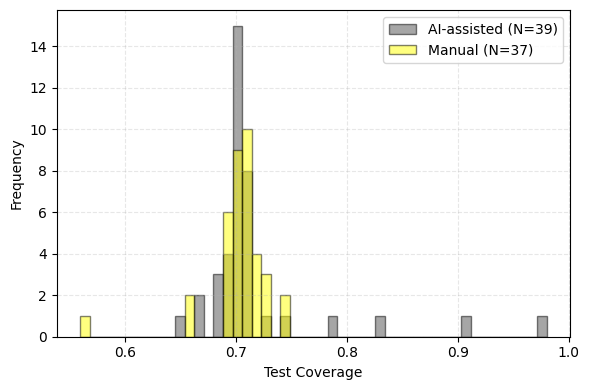

In [6]:
plt.figure(figsize=(6, 4))

# Drop NaNs and count
ai_coverage = task1_ai_group['coverage'].dropna()
manual_coverage = task1_manual_group['coverage'].dropna()

# Legend labels with sample sizes
ai_label = f"AI-assisted (N={len(ai_coverage)})"
manual_label = f"Manual (N={len(manual_coverage)})"

# Determine combined min/max for consistent binning
combined_min = min(ai_coverage.min(), manual_coverage.min())
combined_max = max(ai_coverage.max(), manual_coverage.max())
bins = np.linspace(combined_min, combined_max, 50)

# Plot histograms
plt.hist(ai_coverage, bins=bins, 
         color=colors['ai_dark_gray'], alpha=0.5, edgecolor='black', label=ai_label)
plt.hist(manual_coverage, bins=bins, 
         color=colors['manual_work'], alpha=0.5, edgecolor='black', label=manual_label)

# Labels and style
plt.xlabel('Test Coverage')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("figures/task1_coverage_distribution.png", dpi=300)
plt.show()

# Task 2

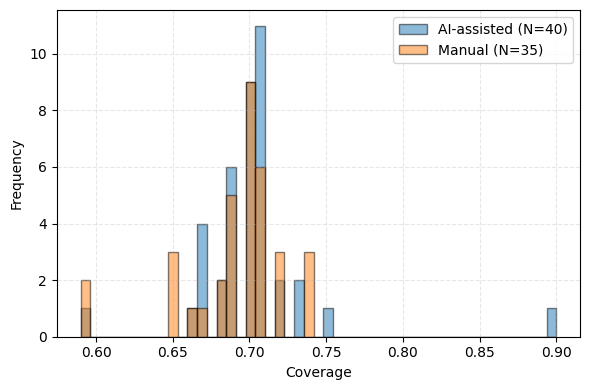

In [7]:
plt.figure(figsize=(6, 4))

# Drop NaNs and count
treatment_coverage = task2_treatment['coverage'].dropna()
control_coverage = task2_control['coverage'].dropna()

# Legend labels with sample sizes
treatment_label = f"AI-assisted (N={len(treatment_coverage)})"
control_label = f"Manual (N={len(control_coverage)})"

# Determine combined min/max for consistent binning
combined_min = min(treatment_coverage.min(), control_coverage.min())
combined_max = max(treatment_coverage.max(), control_coverage.max())
bins = np.linspace(combined_min, combined_max, 50)

# Plot histograms
plt.hist(treatment_coverage, bins=bins, 
         color=colors['treatment_blue'], alpha=0.5, edgecolor='black', label=treatment_label)
plt.hist(control_coverage, bins=bins, 
         color=colors['control_orange'], alpha=0.5, edgecolor='black', label=control_label)

# Labels and style
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("figures/task2_coverage_distribution.png", dpi=300)
plt.show()

## Inferential statistics

In [8]:
treatment = task2_treatment['coverage'].dropna()
control = task2_control['coverage'].dropna()

# Step 1: Perform the Shapiro-Wilk test for normality
shapiro_treatment = shapiro(treatment)
shapiro_control = shapiro(control)

# Step 2: Display the results
print("Shapiro-Wilk Test for Normality:")
print(f"Treatment Group: W={shapiro_treatment.statistic:.4f}, p-value={shapiro_treatment.pvalue:.4e}")
print(f"Control Group: W={shapiro_control.statistic:.4f}, p-value={shapiro_control.pvalue:.4e}")

Shapiro-Wilk Test for Normality:
Treatment Group: W=0.6800, p-value=4.6500e-08
Control Group: W=0.8503, p-value=2.3371e-04


We reject the null hypothesis of normality.

In [9]:
# Step 2: Wilcoxon Rank-Sum Test (non-parametric test)
statistic, p_value = ranksums(treatment, control)
print(f"Wilcoxon Rank-Sum Test: Statistic={statistic:.4f}, p-value={p_value:.4e}")

Wilcoxon Rank-Sum Test: Statistic=0.6903, p-value=4.9001e-01


We reject the null hypothesis of difference.

In [10]:
# Function to compute Cliff's delta
def cliffs_delta(x, y):
    """Compute Cliff's delta for effect size."""
    x, y = x.dropna(), y.dropna()
    n_x, n_y = len(x), len(y)
    more = sum(i > j for i in x for j in y)
    less = sum(i < j for i in x for j in y)
    delta = (more - less) / (n_x * n_y)
    return delta

# Compute Cliff's delta for Code Coverage
delta_coverage = cliffs_delta(task2_treatment['coverage'], task2_control['coverage'])

# Print result
print(f"Cliff's Delta for Code Coverage: {delta_coverage:.4f}")

# Interpret effect size magnitude
abs_delta = abs(delta_coverage)
if abs_delta < 0.147:
    magnitude = "Negligible"
elif abs_delta < 0.33:
    magnitude = "Small"
elif abs_delta < 0.474:
    magnitude = "Medium"
else:
    magnitude = "Large"

print(f"Effect Size Interpretation: {magnitude}")

Cliff's Delta for Code Coverage: 0.0929
Effect Size Interpretation: Negligible


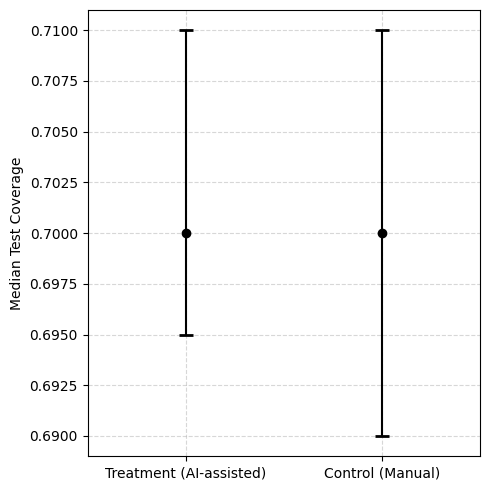

Bootstrap Confidence Intervals (95% CI) for Median Test Coverage:
Treatment (AI-assisted): 0.70  (95% CI: 0.69 - 0.71)
Control (Manual):       0.70  (95% CI: 0.69 - 0.71)


In [11]:
def bootstrap_ci_median(data, n_bootstraps=1000000, ci=95):
    """Compute percentile bootstrap confidence interval for the median"""
    boot_medians = [np.median(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_medians, (100 - ci) / 2)
    upper = np.percentile(boot_medians, 100 - (100 - ci) / 2)
    return np.median(data), lower, upper

# Compute Bootstrap CIs for median Code Coverage in Task 2
treatment_median, treatment_lower, treatment_upper = bootstrap_ci_median(task2_treatment['coverage'].dropna())
control_median, control_lower, control_upper = bootstrap_ci_median(task2_control['coverage'].dropna())

# Error bars
lower_bounds = [treatment_median - treatment_lower, control_median - control_lower]
upper_bounds = [treatment_upper - treatment_median, control_upper - control_median]
yerr = [lower_bounds, upper_bounds]

# Plot
plt.figure(figsize=(5, 5))
x_pos = [0, 1]
medians = [treatment_median, control_median]

plt.errorbar(x_pos, medians, yerr=yerr, fmt='o', capsize=5, capthick=2, color='black')
plt.xticks(x_pos, ['Treatment (AI-assisted)', 'Control (Manual)'])
plt.xlim(-0.5, 1.5)
plt.ylabel('Median Test Coverage')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("figures/task2_bootstrap_coverage_ci.png", dpi=300)
plt.show()

# Print summary
print("Bootstrap Confidence Intervals (95% CI) for Median Test Coverage:")
print(f"Treatment (AI-assisted): {treatment_median:.2f}  (95% CI: {treatment_lower:.2f} - {treatment_upper:.2f})")
print(f"Control (Manual):       {control_median:.2f}  (95% CI: {control_lower:.2f} - {control_upper:.2f})")